In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPool2D, Flatten, GlobalAveragePooling2D,
                                     Dense, Dropout, Input)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy, Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

base_dir = '/content/drive/MyDrive/mamografii'

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    f'{base_dir}/train',
    labels='inferred',
    label_mode='binary',
    color_mode='grayscale',
    batch_size=32,
    image_size=(224,224),
    shuffle=True,
    seed=42
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    f'{base_dir}/valid',
    labels='inferred',
    label_mode='binary',
    color_mode='grayscale',
    batch_size=32,
    image_size=(224,224),
    shuffle=False
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    f'{base_dir}/test',
    labels='inferred',
    label_mode='binary',
    color_mode='grayscale',
    batch_size=32,
    image_size=(224,224),
    shuffle=False
)

Found 2371 files belonging to 2 classes.
Found 675 files belonging to 2 classes.
Found 336 files belonging to 2 classes.


In [5]:
train_ds = train_ds.map(lambda x, y: (x/255.0, y))
val_ds   = val_ds.map(lambda x, y: (x/255.0, y))
test_ds  = test_ds.map(lambda x, y: (x/255.0, y))

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)


/tmp/ipython-input-1580042348.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(int(labels[i].numpy()))


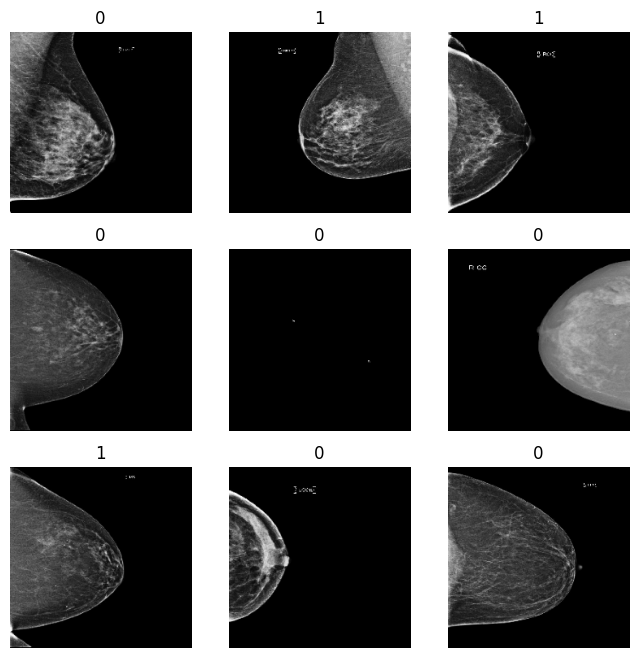

In [7]:
plt.figure(figsize=(8,8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        img = images[i].numpy().squeeze(-1)
        plt.imshow(img, cmap='gray')
        plt.title(int(labels[i].numpy()))
        plt.axis('off')
plt.show()

In [8]:
model = Sequential([
    Input(shape=(224,224,1)),
    Conv2D(32, 3, activation='relu'),
    MaxPool2D(2),
    Conv2D(64, 3, activation='relu'),
    MaxPool2D(2),
    Conv2D(128, 3, activation='relu'),
    MaxPool2D(2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid'),
], name="clasificarea_tumorilor_mamare")

model.summary()


Model: "clasificarea_tumorilor_mamare"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,176,705 (42.64 MB)

 Trainable params: 11,176,705 (42.64 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from tensorflow.keras.optimizers import AdamW

optimizer = AdamW(
    learning_rate=1e-4,
    weight_decay=1e-4
)

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy','recall']
)

In [10]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5)
]

In [11]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.6252 - loss: 0.6733 - recall: 0.1365 - val_accuracy: 0.6637 - val_loss: 0.6430 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.6605 - loss: 0.6509 - recall: 0.0222 - val_accuracy: 0.6637 - val_loss: 0.6383 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.6699 - loss: 0.6412 - recall: 0.0164 - val_accuracy: 0.6637 - val_loss: 0.6310 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.6680 - loss: 0.6242 - recall: 0.0651 - val_accuracy: 0.6681 - val_loss: 0.6286 - val_recall: 0.0661 - learning_rate: 1.0000e-04
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.6829 - loss: 0.6166 - recall: 0.1949 - val_accuracy: 0.6696 - val_loss: 0.6282 - val_recall: 0.1498 - learning_rate: 1.0000e-04
Epoch 6/50
75/75 ━━━━━━

In [12]:
results = model.evaluate(test_ds)
print("Test loss, Test accuracy, Test recall:", results)

11/11 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.8202 - loss: 0.5019 - recall: 0.1037
Test loss, Test accuracy, Test recall: [0.6468719244003296, 0.6398809552192688, 0.1640625]


In [13]:

import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.metrics import BinaryAccuracy

In [14]:
X_test = np.vstack([x.numpy() for x, y in test_ds])
y_test = np.concatenate([y.numpy() for x, y in test_ds]).astype(int)
preds_prob = model.predict(test_ds)
y_pred = (preds_prob > 0.5).astype(int).flatten()
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-malignant', 'Malignant']))

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Classification Report:
               precision    recall  f1-score   support

Non-malignant       0.64      0.93      0.76       208
    Malignant       0.60      0.16      0.26       128

     accuracy                           0.64       336
    macro avg       0.62      0.55      0.51       336
 weighted avg       0.63      0.64      0.57       336



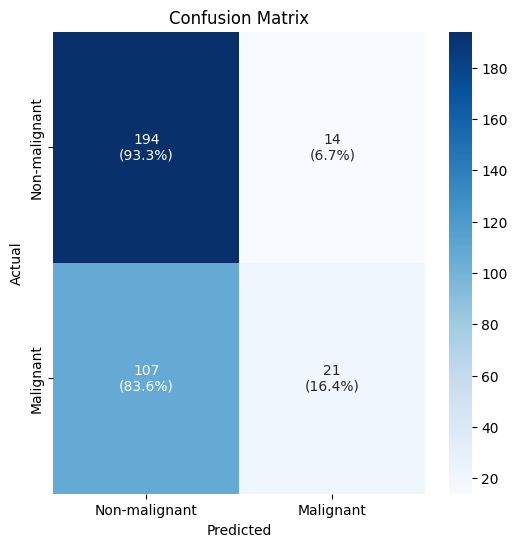

In [15]:
cm = confusion_matrix(y_test, y_pred)
cm_pct = cm.astype('float') / cm.sum(axis=1)[:, None] * 100

annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot[i, j] = f"{cm[i, j]}\n({cm_pct[i, j]:.1f}%)"

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=annot, fmt="", cmap="Blues",
            xticklabels=['Non-malignant', 'Malignant'],
            yticklabels=['Non-malignant', 'Malignant'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

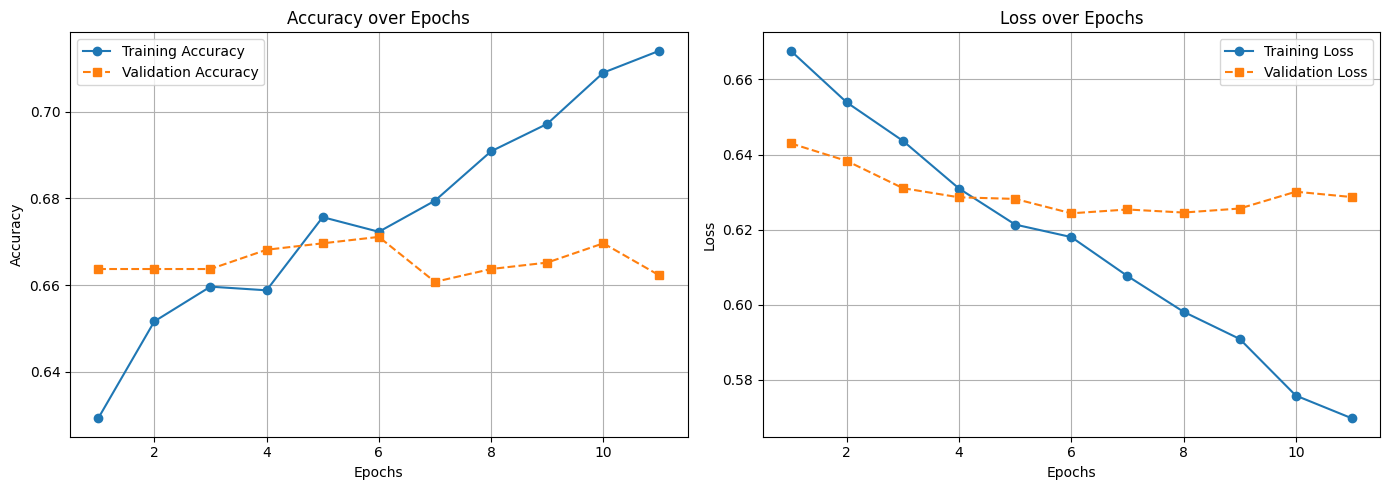

In [16]:
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(epochs, train_acc, 'o-', label='Training Accuracy')
axes[0].plot(epochs, val_acc, 's--', label='Validation Accuracy')
axes[0].set_title('Accuracy over Epochs')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)
axes[1].plot(epochs, train_loss, 'o-', label='Training Loss')
axes[1].plot(epochs, val_loss, 's--', label='Validation Loss')
axes[1].set_title('Loss over Epochs')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)
plt.tight_layout()
plt.show()

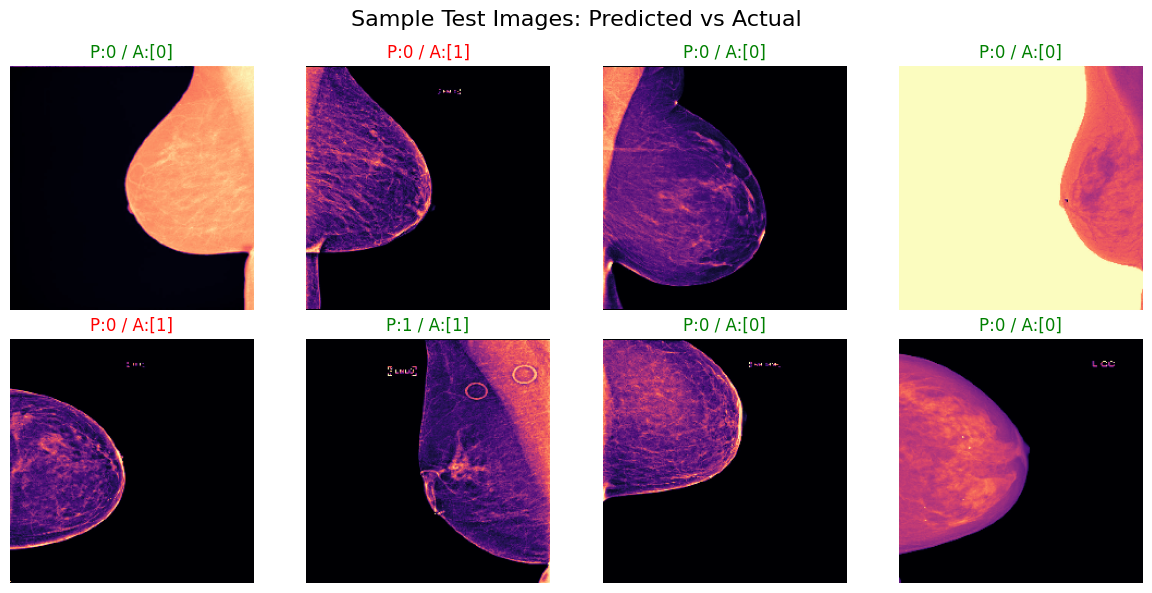

In [17]:
plt.figure(figsize=(12, 6))
indices = np.random.choice(len(X_test), size=8, replace=False)
for i, idx in enumerate(indices):
    ax = plt.subplot(2, 4, i+1)
    img = X_test[idx].squeeze()
    plt.imshow(img, cmap='magma')
    title_color = 'green' if y_pred[idx] == y_test[idx] else 'red'
    plt.title(f"P:{y_pred[idx]} / A:{y_test[idx]}", color=title_color)
    plt.axis('off')
plt.suptitle("Sample Test Images: Predicted vs Actual", fontsize=16)
plt.tight_layout()
plt.show()